In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torchvision.models import efficientnet_b0, mobilenet_v3_small, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 数据增强
class PathoAugment:
    def __call__(self, img):
        # 添加具体增强操作
        return img

# 模型定义
class CropDiseaseNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 主干网络
        self.effnet = efficientnet_b0(weights='DEFAULT')  # 使用DEFAULT更通用
        self.mobilenet = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
        
        # 特征融合（修正特征维度）
        effnet_features = 1280
        mobilenet_features = 576
        self.fusion = nn.Sequential(
            nn.Linear(effnet_features + mobilenet_features, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x1 = self.effnet.features(x)
        x1 = nn.AdaptiveAvgPool2d(1)(x1).flatten(1)
        
        x2 = self.mobilenet.features(x)
        x2 = nn.AdaptiveAvgPool2d(1)(x2).flatten(1)
        
        fused = torch.cat([x1, x2], dim=1)
        return self.classifier(self.fusion(fused))

# 训练函数
def train():
    # 初始化
    model = CropDiseaseNet().cuda()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    scaler = amp.GradScaler()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # 数据加载（添加transform）
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])
    train_set = datasets.CIFAR10(root='E:\Datasets\cifar-10-batches-py', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, 
                            num_workers=2, pin_memory=True)

    test_set = datasets.CIFAR10(root='E:\Datasets\cifar-10-batches-py', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, 
                            num_workers=2, pin_memory=True)

    # 训练循环
    for epoch in range(30):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            
            with amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            
            if (i+1) % 4 == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            if i % 10 == 0:
                mem = torch.cuda.memory_allocated()/1e9
                print(f'Epoch {epoch} | Batch {i} | Loss: {loss.item():.3f} | Mem: {mem:.2f}GB')
        
        scheduler.step()

        # 测试
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Epoch {epoch} | Test Accuracy: {100 * correct / total:.2f}%')

if __name__ == "__main__":
    train()

C:\Users\SYH\AppData\Local\Temp\ipykernel_30568\1833790606.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


100%|██████████| 170498071/170498071 [03:29<00:00, 815663.92it/s] 


Extracting E:\Datasets\cifar-10-batches-py\cifar-10-python.tar.gz to E:\Datasets\cifar-10-batches-py
Files already downloaded and verified


C:\Users\SYH\AppData\Local\Temp\ipykernel_30568\1833790606.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 0 | Batch 0 | Loss: 2.361 | Mem: 0.13GB
Epoch 0 | Batch 10 | Loss: 2.230 | Mem: 0.18GB
Epoch 0 | Batch 20 | Loss: 1.725 | Mem: 0.18GB
Epoch 0 | Batch 30 | Loss: 1.680 | Mem: 0.18GB
Epoch 0 | Batch 40 | Loss: 1.249 | Mem: 0.18GB
Epoch 0 | Batch 50 | Loss: 1.117 | Mem: 0.18GB
Epoch 0 | Batch 60 | Loss: 1.159 | Mem: 0.18GB
Epoch 0 | Batch 70 | Loss: 1.064 | Mem: 0.18GB
Epoch 0 | Batch 80 | Loss: 1.019 | Mem: 0.18GB
Epoch 0 | Batch 90 | Loss: 0.827 | Mem: 0.18GB
Epoch 0 | Batch 100 | Loss: 0.872 | Mem: 0.18GB
Epoch 0 | Batch 110 | Loss: 1.030 | Mem: 0.18GB
Epoch 0 | Batch 120 | Loss: 0.993 | Mem: 0.18GB
Epoch 0 | Batch 130 | Loss: 1.116 | Mem: 0.18GB
Epoch 0 | Batch 140 | Loss: 0.991 | Mem: 0.18GB
Epoch 0 | Batch 150 | Loss: 0.822 | Mem: 0.18GB
Epoch 0 | Batch 160 | Loss: 0.746 | Mem: 0.18GB
Epoch 0 | Batch 170 | Loss: 0.797 | Mem: 0.18GB
Epoch 0 | Batch 180 | Loss: 0.767 | Mem: 0.18GB
Epoch 0 | Batch 190 | Loss: 0.914 | Mem: 0.18GB
Epoch 0 | Batch 200 | Loss: 0.847 | Mem: 0.18GB
Epo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torchvision.models import resnet50,efficientnet_b0, mobilenet_v3_small, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# 数据增强
class PathoAugment:
    def __call__(self, img):
        # 添加具体增强操作
        return img

# 模型定义
class CropDiseaseNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 主干网络
        self.effnet = efficientnet_b0(weights='DEFAULT')  # 使用DEFAULT更通用
        self.mobilenet = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
        
        # 特征融合（修正特征维度）
        effnet_features = 1280
        mobilenet_features = 576
        self.fusion = nn.Sequential(
            nn.Linear(effnet_features + mobilenet_features, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x1 = self.effnet.features(x)
        x1 = nn.AdaptiveAvgPool2d(1)(x1).flatten(1)
        
        x2 = self.mobilenet.features(x)
        x2 = nn.AdaptiveAvgPool2d(1)(x2).flatten(1)
        
        fused = torch.cat([x1, x2], dim=1)
        return self.classifier(self.fusion(fused))

# 训练函数
def train(model, train_loader, val_loader, optimizer, scheduler, scaler, criterion, epochs=30):
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            
            with amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            
            if (i+1) % 4 == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            if i % 10 == 0:
                mem = torch.cuda.memory_allocated()/1e9
                print(f'Epoch {epoch} | Batch {i} | Loss: {loss.item():.3f} | Mem: {mem:.2f}GB')
        
        scheduler.step()

        # 验证
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Epoch {epoch} | Val Accuracy: {100 * correct / total:.2f}%')
    return 100 * correct / total

# 数据增强策略
aug_configs = {
    'baseline': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'std_aug': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'patho_aug': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        PathoAugment(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'full_aug': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        PathoAugment(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# 模型列表
models = {
    'ResNet50': resnet50(weights='DEFAULT'),
    'EfficientNet-B0': efficientnet_b0(weights='DEFAULT'),
    'MobileNetV3': mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT),
    'FusionNet': CropDiseaseNet(num_classes=10)
}

# 训练和评估
results = {}
for model_name, model in models.items():
    model.cuda()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    scaler = amp.GradScaler()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    for aug_name, transform in aug_configs.items():
        train_set = datasets.CIFAR10(root='E:\Datasets\cifar-10-batches-py', train=True, download=False, transform=transform)
        train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

        val_set = datasets.CIFAR10(root='E:\Datasets\cifar-10-batches-py', train=False, download=False, transform=transform)
        val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

        accuracy = train(model, train_loader, val_loader, optimizer, scheduler, scaler, criterion, epochs=5)
        results[(model_name, aug_name)] = accuracy

# 实验结果
augmentation_results = {
    'Baseline': results[('ResNet50', 'baseline')],
    'Standard': results[('ResNet50', 'std_aug')],
    'Pathology': results[('ResNet50', 'patho_aug')],
    'Combined': results[('ResNet50', 'full_aug')]
}

# 可视化实验结果
plt.figure(figsize=(10, 6))
plt.bar(augmentation_results.keys(), augmentation_results.values())
plt.title('Accuracy Gain with Different Augmentation Strategies')
plt.xlabel('Augmentation Type')
plt.ylabel('Accuracy (%)')
plt.ylim(70, 90)
plt.show()

# 可视化注意力图
def visualize_attention(model, img_path):
    model.eval()
    img = aug_configs['full_aug'](Image.open(img_path)).unsqueeze(0).cuda()
    
    # 注册hook获取特征图
    feature_maps = []
    def hook(module, input, output):
        feature_maps.append(output.detach().cpu())
    
    handle = model.effnet._blocks[5].register_forward_hook(hook)
    
    with torch.no_grad():
        _ = model(img)
    
    handle.remove()
    
    # 可视化
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(img_path))
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(feature_maps[0].mean(1).squeeze(), cmap='jet')
    plt.title('Disease Attention')
    plt.show()

# 示例可视化
# 选择CIFAR-10中的一个图像路径
cifar10_image_path = 'E:\Datasets\cifar-10-batches-py\test_batch'  # 这里需要选择一个具体的图像文件路径
visualize_attention(models['FusionNet'], cifar10_image_path)

C:\Users\SYH\AppData\Local\Temp\ipykernel_33236\3173465429.py:136: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
C:\Users\SYH\AppData\Local\Temp\ipykernel_33236\3173465429.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 0 | Batch 0 | Loss: 7.391 | Mem: 0.25GB
Epoch 0 | Batch 10 | Loss: 7.141 | Mem: 0.24GB
Epoch 0 | Batch 20 | Loss: 6.261 | Mem: 0.46GB
Epoch 0 | Batch 30 | Loss: 5.994 | Mem: 0.46GB
Epoch 0 | Batch 40 | Loss: 4.512 | Mem: 0.46GB
Epoch 0 | Batch 50 | Loss: 4.162 | Mem: 0.46GB
Epoch 0 | Batch 60 | Loss: 2.997 | Mem: 0.46GB
Epoch 0 | Batch 70 | Loss: 2.576 | Mem: 0.46GB
Epoch 0 | Batch 80 | Loss: 2.405 | Mem: 0.46GB
Epoch 0 | Batch 90 | Loss: 2.581 | Mem: 0.46GB
Epoch 0 | Batch 100 | Loss: 2.160 | Mem: 0.46GB
Epoch 0 | Batch 110 | Loss: 2.197 | Mem: 0.46GB
Epoch 0 | Batch 120 | Loss: 1.893 | Mem: 0.46GB
Epoch 0 | Batch 130 | Loss: 2.114 | Mem: 0.46GB
Epoch 0 | Batch 140 | Loss: 1.671 | Mem: 0.46GB
Epoch 0 | Batch 150 | Loss: 1.684 | Mem: 0.46GB
Epoch 0 | Batch 160 | Loss: 1.869 | Mem: 0.46GB
Epoch 0 | Batch 170 | Loss: 1.511 | Mem: 0.46GB
Epoch 0 | Batch 180 | Loss: 1.494 | Mem: 0.46GB
Epoch 0 | Batch 190 | Loss: 1.765 | Mem: 0.46GB
Epoch 0 | Batch 200 | Loss: 1.559 | Mem: 0.46GB
Epo

KeyboardInterrupt: 

In [ ]:
import os
import time
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from efficientnet_pytorch import EfficientNet
from PIL import Image
import torch.cuda.amp as amp
import copy
import torch.nn.functional as F
from torchvision import models

# 配置参数
class Config:
    data_root = "E:/Datasets/cifar-10-batches-py"
    batch_size = 32
    num_workers = 4
    num_classes = 10
    epochs = 5
    lr = 3e-4
    T = 3  # 蒸馏温度
    alpha = 0.3  # 蒸馏系数
    device = "cuda" if torch.cuda.is_available() else "cpu"

# 数据加载器
class CIFARDataset(Dataset):
    def __init__(self, split='train', transform=None):
        self.transform = transform or self.default_transform(split)
        self.dataset = datasets.CIFAR10(root=Config.data_root, train=(split == 'train'), download=True, transform=self.transform)
    
    def default_transform(self, split):
        if split == 'train':
            return transforms.Compose([
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                self.PathoAugment()
            ])
        else:
            return transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    class PathoAugment:
        def __call__(self, img):
            if torch.rand(1) < 0.5:
                img = self.add_spot_noise(img)
            if torch.rand(1) < 0.3:
                img = self.simulate_blight(img)
            return img

        def add_spot_noise(self, img):
            c, h, w = img.shape
            for _ in range(torch.randint(3,7,(1,))):
                x = torch.randint(0, w-10, (1,))
                y = torch.randint(0, h-10, (1,))
                img[:, y:y+10, x:x+10] *= torch.empty(1).uniform_(0.7,1.3)
            return img

        def simulate_blight(self, img):
            mask = torch.rand_like(img) > 0.9
            img[mask] = img[mask] * 0.5 + 0.2
            return img

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

# 模型定义
class DynamicFusion(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.weight_net = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x1, x2):
        weights = self.weight_net(torch.cat([x1, x2], dim=1))
        return weights[:,0:1]*x1 + weights[:,1:2]*x2

class EnhancedCropDiseaseNet(nn.Module):
    def __init__(self, num_classes=Config.num_classes):
        super().__init__()
        # 双主干网络
        self.effnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.mobilenet = models.mobilenet_v3_small(pretrained=True)
        
        # 动态融合
        self.fusion = DynamicFusion(1280+576)
        
        # 注意力机制
        self.attention = nn.Sequential(
            nn.Linear(1280+576, 512),
            nn.ReLU(),
            nn.Linear(512, 1280+576),
            nn.Sigmoid()
        )
        
        # 分类头
        self.classifier = nn.Sequential(
            nn.Linear(1280+576, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x1 = self.effnet.extract_features(x)
        x1 = nn.AdaptiveAvgPool2d(1)(x1).flatten(1)
        
        x2 = self.mobilenet.features(x)
        x2 = nn.AdaptiveAvgPool2d(1)(x2).flatten(1)
        
        # 动态融合
        fused = self.fusion(x1, x2)
        
        # 注意力加权
        attn = self.attention(fused)
        fused = fused * attn
        
        return self.classifier(fused)

class MomentumNetwork(nn.Module):
    def __init__(self, base_model, momentum_alpha=0.999):
        super(MomentumNetwork, self).__init__()
        self.base_model = base_model
        self.momentum_base_model = copy.deepcopy(base_model)
        self.momentum_alpha = momentum_alpha
        for param in self.momentum_base_model.parameters():
            param.requires_grad = False
    
    @torch.no_grad()
    def update_momentum_network(self):
        for current_params, momentum_params in zip(self.base_model.parameters(), self.momentum_base_model.parameters()):
            momentum_params.data = momentum_params.data * self.momentum_alpha + current_params.data * (1 - self.momentum_alpha)
    
    def forward(self, x):
        return self.base_model(x), self.momentum_base_model(x)

# 知识蒸馏训练器
class DistillTrainer:
    def __init__(self, student, teacher=None):
        self.student = student.to(Config.device)
        self.teacher = teacher.to(Config.device) if teacher else None
        self.scaler = amp.GradScaler()
        self.optimizer = optim.AdamW(student.parameters(), lr=Config.lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'max', patience=3)
        
    def train_epoch(self, train_loader):
        self.student.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(Config.device), labels.to(Config.device)
            
            with amp.autocast():
                student_out = self.student(images)
                loss = self.calc_loss(student_out, labels, images)
            
            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            total_loss += loss.item()
        return total_loss / len(train_loader)
    
    def calc_loss(self, student_out, labels, images):
        ce_loss = nn.CrossEntropyLoss(label_smoothing=0.1)(student_out, labels)
        
        if self.teacher:
            with torch.no_grad():
                teacher_out = self.teacher(images)
            distill_loss = nn.KLDivLoss(reduction='batchmean')(
                F.log_softmax(student_out/Config.T, dim=1),
                F.softmax(teacher_out/Config.T, dim=1)
            )
            return (1-Config.alpha)*ce_loss + Config.alpha*Config.T**2*distill_loss
        return ce_loss

# 实验管理
class Experiment:
    def __init__(self):
        self.model_dict = {
            "EfficientNet-B0": EfficientNet.from_pretrained('efficientnet-b0').to(Config.device),
            "MobileNetV3": models.mobilenet_v3_small(pretrained=True).to(Config.device),
            "FusionNet": EnhancedCropDiseaseNet().to(Config.device),
            "MomentumNet": MomentumNetwork(EfficientNet.from_pretrained('efficientnet-b0')).to(Config.device)
        }
        self.results = []
        
    def run(self):
        train_set = CIFARDataset('train')
        val_set = CIFARDataset('val')
        
        for name, model in self.model_dict.items():
            print(f"\nTraining {name}...")
            train_loader = DataLoader(train_set, Config.batch_size, shuffle=True, 
                                    num_workers=Config.num_workers, pin_memory=True)
            val_loader = DataLoader(val_set, Config.batch_size, 
                                  num_workers=Config.num_workers)
            
            # 初始化教师模型
            teacher = models.mobilenet_v3_small(pretrained=True).to(Config.device) if name == "FusionNet" else None
            
            trainer = DistillTrainer(model, teacher)
            best_acc = 0
            patience = 5
            
            for epoch in range(Config.epochs):
                start_time = time.time()
                loss = trainer.train_epoch(train_loader)
                val_acc = self.evaluate(model, val_loader)
                trainer.scheduler.step(val_acc)
                
                # 更新动量网络
                if isinstance(model, MomentumNetwork):
                    model.update_momentum_network()
                    
                # 早停机制
                if val_acc > best_acc:
                    best_acc = val_acc
                    patience = 5
                    torch.save(model.state_dict(), f"best_{name}.pth")
                else:
                    patience -=1
                
                print(f"Epoch {epoch+1}/{Config.epochs} | Loss: {loss:.4f} | Val Acc: {val_acc:.2%} | Time: {time.time()-start_time:.1f}s")
                
                if patience <=0:
                    print("Early stopping")
                    break
            
            self.results.append({
                'model': name,
                'accuracy': best_acc,
                'params': sum(p.numel() for p in model.parameters())/1e6
            })
    
    def evaluate(self, model, loader):
        model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(Config.device), labels.to(Config.device)
                outputs = model(images)[0] if isinstance(model, MomentumNetwork) else model(images)
                correct += (outputs.argmax(1) == labels).sum().item()
        return correct / len(loader.dataset)

    def visualize(self):
        plt.figure(figsize=(12,6))
        
        # 精度对比
        plt.subplot(121)
        names = [res['model'] for res in self.results]
        accs = [res['accuracy']*100 for res in self.results]
        plt.bar(names, accs)
        plt.title("Accuracy Comparison")
        plt.ylabel("Accuracy (%)")
        plt.ylim(70,95)
        
        # 参数量对比
        plt.subplot(122)
        params = [res['params'] for res in self.results]
        plt.bar(names, params)
        plt.title("Parameter Comparison")
        plt.ylabel("Parameters (M)")        
        plt.tight_layout()
        plt.savefig("results.png")
        plt.show()

    def tsne_visualize(self, model_name, subset='val'):
        model = self.model_dict[model_name].eval()
        dataset = CIFARDataset(subset)
        dataloader = DataLoader(dataset, batch_size=Config.batch_size, num_workers=Config.num_workers)
        
        features = []
        labels = []
        with torch.no_grad():
            for images, lbls in dataloader:
                images, lbls = images.to(Config.device), lbls.to(Config.device)
                feat = model(images)[0] if isinstance(model, MomentumNetwork) else model(images)
                features.append(feat.cpu().numpy())
                labels.extend(lbls.cpu().numpy())
        
        features = np.concatenate(features)
        labels = np.array(labels)
        
        pca = PCA(n_components=50)
        reduced_features = pca.fit_transform(features)
        tsne = TSNE(n_components=2, random_state=42)
        tsne_features = tsne.fit_transform(reduced_features)
        
        plt.figure(figsize=(10, 10))
        scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='tab10')
        legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
        plt.gca().add_artist(legend1)
        plt.title(f't-SNE Visualization of {model_name}')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.savefig(f"{model_name}_tsne.png")
        plt.show()

if __name__ == "__main__":
    exp = Experiment()
    exp.run()
    exp.visualize()
    
    # t-SNE visualization for each model
    for model_name in ["EfficientNet-B0", "MobileNetV3", "FusionNet", "MomentumNet"]:
        exp.tsne_visualize(model_name)
    
    # 模型量化
    model = EnhancedCropDiseaseNet().cpu()
    model.load_state_dict(torch.load("best_FusionNet.pth"))
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.Linear}, dtype=torch.qint8
    )
    torch.save(quantized_model.state_dict(), "quantized_fusionnet.pth")

    # 小样本实验（假设我们只用一半的数据）
    small_train_set = CIFARDataset('train')
    small_val_set = CIFARDataset('val')
    small_train_set.samples = small_train_set.samples[:len(small_train_set)//2]
    small_val_set.samples = small_val_set.samples[:len(small_val_set)//2]

    small_exp = Experiment()
    small_model_dict = {
        "Small_EfficientNet-B0": EfficientNet.from_pretrained('efficientnet-b0').to(Config.device),
        "Small_MobileNetV3": models.mobilenet_v3_small(pretrained=True).to(Config.device),
        "Small_FusionNet": EnhancedCropDiseaseNet().to(Config.device),
        "Small_MomentumNet": MomentumNetwork(EfficientNet.from_pretrained('efficientnet-b0')).to(Config.device)
    }
    small_exp.model_dict = small_model_dict

    for name, model in small_exp.model_dict.items():
        print(f"\nTraining Small {name}...")
        train_loader = DataLoader(small_train_set, Config.batch_size, shuffle=True, 
                                num_workers=Config.num_workers, pin_memory=True)
        val_loader = DataLoader(small_val_set, Config.batch_size, 
                              num_workers=Config.num_workers)
        
        # 初始化教师模型
        teacher = models.mobilenet_v3_small(pretrained=True).to(Config.device) if name == "Small_FusionNet" else None
        
        trainer = DistillTrainer(model, teacher)
        best_acc = 0
        patience = 5
        
        for epoch in range(Config.epochs):
            start_time = time.time()
            loss = trainer.train_epoch(train_loader)
            val_acc = small_exp.evaluate(model, val_loader)
            trainer.scheduler.step(val_acc)
            
            # 更新动量网络
            if isinstance(model, MomentumNetwork):
                model.update_momentum_network()
                
            # 早停机制
            if val_acc > best_acc:
                best_acc = val_acc
                patience = 5
                torch.save(model.state_dict(), f"small_best_{name}.pth")
            else:
                patience -=1
            
            print(f"Epoch {epoch+1}/{Config.epochs} | Loss: {loss:.4f} | Val Acc: {val_acc:.2%} | Time: {time.time()-start_time:.1f}s")
            
            if patience <=0:
                print("Early stopping")
                break
        
        small_exp.results.append({
            'model': name,
            'accuracy': best_acc,
            'params': sum(p.numel() for p in model.parameters())/1e6
        })

    small_exp.visualize()

Loaded pretrained weights for efficientnet-b0


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Files already downloaded and verified
Files already downloaded and verified

Training EfficientNet-B0...


C:\Users\SYH\AppData\Local\Temp\ipykernel_33236\2856450224.py:162: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler()


进行横向对比实验，我们需要加载预训练的权重到EfficientNet-B4、ConvNeXt-Tiny和Swin-Tiny模型中，并实现FusionNet。然后我们将这些模型与我们提出的DS-FusionNet一起进行评估。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

def load_swin_tiny(pretrained=True):
    model = models.swin_t(pretrained=pretrained)
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, 10)
    return model

class FusionNet(nn.Module):
    def __init__(self):
        super(FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        self.fc = nn.Linear(2 * 1000, 10)

    def forward(self, x):
        eff_out = self.efficientnet(x)
        convnext_out = self.convnext(x)
        fused_out = torch.cat((eff_out, convnext_out), dim=1)
        out = self.fc(fused_out)
        return out

class DS_FusionNet(nn.Module):
    def __init__(self):
        super(DS_FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        self.deformable_conv = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        eff_out_feat = self.efficientnet.features(x)
        convnext_out_feat = self.convnext.features(x)
        
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        fused_feat = self.deformable_conv(fused_feat)
        fused_feat = self.avgpool(fused_feat)
        fused_feat = fused_feat.view(fused_feat.size(0), -1)
        out = self.fc(fused_feat)
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher)
        loss.backward()
        optimizer.step()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_dict = {
    'EfficientNetB4': load_efficientnet_b4(pretrained=True).to(device),
    'ConvNeXtTiny': load_convnext_tiny(pretrained=True).to(device),
    'SwinTiny': load_swin_tiny(pretrained=True).to(device),
    'FusionNet': FusionNet().to(device),
    'DS_FusionNet': DS_FusionNet().to(device)
}

optimizers = {name: optim.Adam(model.parameters(), lr=0.001) for name, model in models_dict.items()}
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

for epoch in range(1, 11):
    for name, model in models_dict.items():
        optimizer = optimizers[name]
        print(f'Training {name}...')
        train(model, teacher_model, device, train_loader, optimizer, epoch)
        print(f'Evaluating {name}...')
        test(model, device, test_loader)

# t-SNE可视化
def visualize_tsne(model, dataloader, num_samples=1000):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            if i * len(data) >= num_samples:
                break
            data, target = data.to(device), target.to(device)
            feature_map = model.features[:-1](data)
            feature_map = feature_map.mean(dim=(2, 3))
            features.append(feature_map.cpu().numpy())
            labels.extend(target.numpy())

    features = np.concatenate(features)
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title('t-SNE visualization of {} features'.format(name))
    plt.show()

for name, model in models_dict.items():
    print(f'Visualizing {name}...')
    visualize_tsne(model, test_loader)





100%|██████████| 170498071/170498071 [00:47<00:00, 3604471.70it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to C:\Users\SYH/.cache\torch\hub\checkpoints\efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:22<00:00, 3.41MB/s]
d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:223: Us

Training EfficientNetB4...


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torch\nn\functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Evaluating EfficientNetB4...

Test set: Average loss: 0.1863, Accuracy: 9630/10000 (96%)

Training ConvNeXtTiny...
Evaluating ConvNeXtTiny...

Test set: Average loss: 0.4068, Accuracy: 8775/10000 (88%)

Training SwinTiny...
Evaluating SwinTiny...

Test set: Average loss: 1.7590, Accuracy: 3548/10000 (35%)

Training FusionNet...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x20 and 2000x10)

这段代码仅包含FusionNet和DS_FusionNet的实现、训练和评估过程。这样可以确保我们专注于这两个模型，并解决之前遇到的问题。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 减少批量大小
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 从64改为16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # 从64改为16

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

class FusionNet(nn.Module):
    def __init__(self):
        super(FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        self.fc = nn.Linear(20, 10)  # Corrected input dimension

    def forward(self, x):
        eff_out = self.efficientnet(x)
        convnext_out = self.convnext(x)
        fused_out = torch.cat((eff_out, convnext_out), dim=1)
        out = self.fc(fused_out)
        return out

class DS_FusionNet(nn.Module):
    def __init__(self):
        super(DS_FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        self.deformable_conv = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        eff_out_feat = self.efficientnet.features(x)
        convnext_out_feat = self.convnext.features(x)
        
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        fused_feat = self.deformable_conv(fused_feat)
        fused_feat = self.avgpool(fused_feat)
        fused_feat = fused_feat.view(fused_feat.size(0), -1)
        out = self.fc(fused_feat)
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher) / accumulation_steps
        
        loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_dict = {
    'FusionNet': FusionNet().to(device),
    'DS_FusionNet': DS_FusionNet().to(device)
}

optimizers = {name: optim.Adam(model.parameters(), lr=0.001) for name, model in models_dict.items()}
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

for epoch in range(1, 11):
    for name, model in models_dict.items():
        optimizer = optimizers[name]
        print(f'Training {name}...')
        train(model, teacher_model, device, train_loader, optimizer, epoch)
        print(f'Evaluating {name}...')
        test(model, device, test_loader)

# t-SNE可视化
def visualize_tsne(model, dataloader, num_samples=1000):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            if i * len(data) >= num_samples:
                break
            data, target = data.to(device), target.to(device)
            feature_map = model.features[:-1](data)
            feature_map = feature_map.mean(dim=(2, 3))
            features.append(feature_map.cpu().numpy())
            labels.extend(target.numpy())

    features = np.concatenate(features)
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title('t-SNE visualization of {} features'.format(name))
    plt.show()

for name, model in models_dict.items():
    print(f'Visualizing {name}...')
    visualize_tsne(model, test_loader)





Files already downloaded and verified
Files already downloaded and verified


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You 

Training FusionNet...


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torch\nn\functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Evaluating FusionNet...

Test set: Average loss: 0.1881, Accuracy: 9645/10000 (96%)

Training DS_FusionNet...


RuntimeError: Given groups=1, weight of size [64, 128, 3, 3], expected input[16, 2560, 7, 7] to have 128 channels, but got 2560 channels instead

训练和可视化 FusionNet

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 减少批量大小
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 从64改为16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # 从64改为16

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

class FusionNet(nn.Module):
    def __init__(self):
        super(FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        self.fc = nn.Linear(20, 10)  # Corrected input dimension

    def forward(self, x):
        eff_out = self.efficientnet(x)
        convnext_out = self.convnext(x)
        fused_out = torch.cat((eff_out, convnext_out), dim=1)
        out = self.fc(fused_out)
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher) / accumulation_steps
        
        loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_labels

# t-SNE可视化
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# PCA可视化
def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# 混淆矩阵可视化
def plot_confusion_matrix(all_preds, all_labels, title):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# 计算指标
def calculate_metrics(model, teacher_model, device, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return total_loss, accuracy

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FusionNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, 11):
    print(f'Training FusionNet...')
    train(model, teacher_model, device, train_loader, optimizer, epoch)
    print(f'Evaluating FusionNet...')
    all_preds, all_labels = test(model, device, test_loader)

    # Collecting training and testing metrics for learning curves
    train_loss, train_acc = calculate_metrics(model, teacher_model, device, train_loader)
    test_loss, test_acc = calculate_metrics(model, None, device, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

print(f'Visualizing FusionNet...')

# Extract features for visualization
features = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        feature_map = model.features[:-1](data)
        feature_map = feature_map.mean(dim=(2, 3))
        features.append(feature_map.cpu().numpy())
        labels.extend(target.numpy())

features = np.concatenate(features)
labels = np.array(labels)

visualize_tsne(features, labels, 't-SNE Visualization of FusionNet Features')
visualize_pca(features, labels, 'PCA Visualization of FusionNet Features')
plot_confusion_matrix(all_preds, all_labels, 'Confusion Matrix of FusionNet')

# Plotting Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()





Files already downloaded and verified
Files already downloaded and verified
Training FusionNet...
Evaluating FusionNet...

Test set: Average loss: 0.1791, Accuracy: 9654/10000 (97%)

Training FusionNet...
Evaluating FusionNet...

Test set: Average loss: 0.1818, Accuracy: 9647/10000 (96%)

Training FusionNet...
Evaluating FusionNet...

Test set: Average loss: 0.1814, Accuracy: 9689/10000 (97%)

Training FusionNet...
Evaluating FusionNet...

Test set: Average loss: 0.1778, Accuracy: 9677/10000 (97%)

Training FusionNet...
Evaluating FusionNet...

Test set: Average loss: 0.1849, Accuracy: 9650/10000 (96%)

Training FusionNet...
Evaluating FusionNet...

Test set: Average loss: 0.1887, Accuracy: 9635/10000 (96%)

Training FusionNet...
Evaluating FusionNet...

Test set: Average loss: 0.1970, Accuracy: 9616/10000 (96%)

Training FusionNet...
Evaluating FusionNet...

Test set: Average loss: 0.1853, Accuracy: 9654/10000 (97%)

Training FusionNet...
Evaluating FusionNet...


KeyboardInterrupt: 

训练和可视化 DS_FusionNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 减少批量大小
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 从64改为16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # 从64改为16

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

class DS_FusionNet(nn.Module):
    def __init__(self):
        super(DS_FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        self.deformable_conv = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        eff_out_feat = self.efficientnet.features(x)
        convnext_out_feat = self.convnext.features(x)
        
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        fused_feat = self.deformable_conv(fused_feat)
        fused_feat = self.avgpool(fused_feat)
        fused_feat = fused_feat.view(fused_feat.size(0), -1)
        out = self.fc(fused_feat)
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher) / accumulation_steps
        
        loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_labels

# t-SNE可视化
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# PCA可视化
def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# 混淆矩阵可视化
def plot_confusion_matrix(all_preds, all_labels, title):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# 计算指标
def calculate_metrics(model, teacher_model, device, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return total_loss, accuracy

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DS_FusionNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, 11):
    print(f'Training DS_FusionNet...')
    train(model, teacher_model, device, train_loader, optimizer, epoch)
    print(f'Evaluating DS_FusionNet...')
    all_preds, all_labels = test(model, device, test_loader)

    # Collecting training and testing metrics for learning curves
    train_loss, train_acc = calculate_metrics(model, teacher_model, device, train_loader)
    test_loss, test_acc = calculate_metrics(model, None, device, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

print(f'Visualizing DS_FusionNet...')

# Extract features for visualization
features = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        feature_map = model.features[:-1](data)
        feature_map = feature_map.mean(dim=(2, 3))
        features.append(feature_map.cpu().numpy())
        labels.extend(target.numpy())

features = np.concatenate(features)
labels = np.array(labels)

visualize_tsne(features, labels, 't-SNE Visualization of DS_FusionNet Features')
visualize_pca(features, labels, 'PCA Visualization of DS_FusionNet Features')
plot_confusion_matrix(all_preds, all_labels, 'Confusion Matrix of DS_FusionNet')

# Plotting Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()





说明
数据预处理: 使用 transforms 对 CIFAR-10 数据集进行预处理。
模型定义: 包括 EfficientNet-B4, ConvNeXt-Tiny 和 Swin-Tiny。
双向知识蒸馏损失函数: 实现了知识蒸馏的损失计算。
训练和测试函数: 分别用于模型的训练和评估。
可视化函数:
visualize_tsne: 使用 t-SNE 进行降维和可视化。
visualize_pca: 使用 PCA 进行降维和可视化。
visualize_umap: 使用 UMAP 进行降维和可视化。
plot_confusion_matrix: 绘制混淆矩阵以评估模型性能。
plot_learning_curves: 绘制学习曲线以监控训练过程中的损失和准确率变化。
主程序: 初始化模型、优化器和教师模型，进行训练和测试，并调用相应的可视化函数。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

def load_swin_tiny(pretrained=True):
    model = models.swin_t(pretrained=pretrained)
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, 10)
    return model

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher)
        loss.backward()
        optimizer.step()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_labels

# t-SNE可视化
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# PCA可视化
def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()


# 混淆矩阵可视化
def plot_confusion_matrix(all_preds, all_labels, title):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# 学习曲线
def plot_learning_curves(train_losses, train_accuracies, test_losses, test_accuracies, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), train_losses, label='Train Loss')
    plt.plot(range(1, 11), test_losses, label='Test Loss')
    plt.title('Learning Curve - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 特征提取函数
def extract_features(model, dataloader, device, num_samples=1000):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            if i * len(data) >= num_samples:
                break
            data, target = data.to(device), target.to(device)
            feature_map = model.features[:-1](data)
            feature_map = feature_map.mean(dim=(2, 3))
            features.append(feature_map.cpu().numpy())
            labels.extend(target.numpy())

    features = np.concatenate(features)
    return features, labels

# 计算指标
def calculate_metrics(model, teacher_model, device, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return total_loss, accuracy

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_dict = {
    'EfficientNetB4': load_efficientnet_b4(pretrained=True).to(device),
    'ConvNeXtTiny': load_convnext_tiny(pretrained=True).to(device),
    'SwinTiny': load_swin_tiny(pretrained=True).to(device)
}

optimizers = {name: optim.Adam(model.parameters(), lr=0.001) for name, model in models_dict.items()}
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

train_losses = {name: [] for name in models_dict}
train_accuracies = {name: [] for name in models_dict}
test_losses = {name: [] for name in models_dict}
test_accuracies = {name: [] for name in models_dict}

for epoch in range(1, 11):
    for name, model in models_dict.items():
        optimizer = optimizers[name]
        print(f'Training {name}...')
        train(model, teacher_model, device, train_loader, optimizer, epoch)
        print(f'Evaluating {name}...')
        all_preds, all_labels = test(model, device, test_loader)
        
        # Collecting training and testing metrics for learning curves
        train_loss, train_acc = calculate_metrics(model, teacher_model, device, train_loader)
        test_loss, test_acc = calculate_metrics(model, None, device, test_loader)
        train_losses[name].append(train_loss)
        train_accuracies[name].append(train_acc)
        test_losses[name].append(test_loss)
        test_accuracies[name].append(test_acc)

# 提取特征用于可视化
features_dict = {}
labels_dict = {}

for name, model in models_dict.items():
    print(f'Extracting features for {name}...')
    features, labels = extract_features(model, test_loader, device)
    features_dict[name] = features
    labels_dict[name] = labels

# 可视化
for name in models_dict.keys():
    print(f'Visualizing {name} using t-SNE...')
    visualize_tsne(features_dict[name], labels_dict[name], f't-SNE visualization of {name} features')

    print(f'Visualizing {name} using PCA...')
    visualize_pca(features_dict[name], labels_dict[name], f'PCA visualization of {name} features')

    
    print(f'Plotting confusion matrix for {name}...')
    plot_confusion_matrix(all_preds, all_labels, f'Confusion Matrix of {name}')

# 绘制学习曲线
for name in models_dict.keys():
    print(f'Plotting learning curves for {name}...')
    plot_learning_curves(train_losses[name], train_accuracies[name], test_losses[name], test_accuracies[name], f'Learning Curves of {name}')





Files already downloaded and verified
Files already downloaded and verified


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You 

Training EfficientNetB4...


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torch\nn\functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 减少批量大小
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 从64改为16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # 从64改为16

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)  # 修改为输出10类
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)  # 修改为输出10类
    return model

class FusionNet(nn.Module):
    def __init__(self):
        super(FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        # Get the number of features from each model after global average pooling
        eff_num_ftrs = self.efficientnet.classifier[1].in_features
        convnext_num_ftrs = self.convnext.classifier[-1].in_features
        # Total number of features after concatenation
        total_ftrs = eff_num_ftrs + convnext_num_ftrs
        self.fc = nn.Linear(total_ftrs, 10)

    def forward(self, x, return_features=False):
        eff_out = self.efficientnet.features(x).mean(dim=(2, 3))
        convnext_out = self.convnext.features(x).mean(dim=(2, 3))
        fused_out = torch.cat((eff_out, convnext_out), dim=1)
        out = self.fc(fused_out)
        if return_features:
            return fused_out, out
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher) / accumulation_steps
        
        loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_labels

# t-SNE可视化
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# PCA可视化
def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# 混淆矩阵可视化
def plot_confusion_matrix(all_preds, all_labels, title):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# 计算指标
def calculate_metrics(model, teacher_model, device, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return total_loss, accuracy

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FusionNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, 2):
    print(f'Training FusionNet...')
    train(model, teacher_model, device, train_loader, optimizer, epoch)
    print(f'Evaluating FusionNet...')
    all_preds, all_labels = test(model, device, test_loader)

    # Collecting training and testing metrics for learning curves
    train_loss, train_acc = calculate_metrics(model, teacher_model, device, train_loader)
    test_loss, test_acc = calculate_metrics(model, None, device, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

print(f'Visualizing FusionNet...')

# Extract features for visualization
features = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        feature_map, _ = model.forward(data, return_features=True)
        features.append(feature_map.cpu().numpy())
        labels.extend(target.numpy())

features = np.concatenate(features)
labels = np.array(labels)

visualize_tsne(features, labels, 't-SNE Visualization of FusionNet Features')
visualize_pca(features, labels, 'PCA Visualization of FusionNet Features')
plot_confusion_matrix(all_preds, all_labels, 'Confusion Matrix of FusionNet')

# Plotting Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()





Files already downloaded and verified
Files already downloaded and verified
Training FusionNet...


KeyboardInterrupt: 

Files already downloaded and verified
Files already downloaded and verified
Training EfficientNetB4...
Evaluating EfficientNetB4...

Test set: Average loss: 0.1683, Accuracy: 9661/10000 (97%)

Training ConvNeXtTiny...
Evaluating ConvNeXtTiny...

Test set: Average loss: 0.3269, Accuracy: 9069/10000 (91%)

Training SwinTiny...
Evaluating SwinTiny...

Test set: Average loss: 1.6383, Accuracy: 3974/10000 (40%)

Extracting features for EfficientNetB4...
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[9], line 231
    229 for name, model in models_dict.items():
    230     print(f'Extracting features for {name}...')
--> 231     features, labels = extract_features(model, test_loader, device)
    232     features_dict[name] = features
    233     labels_dict[name] = labels

Cell In[9], line 170, in extract_features(model, dataloader, device, num_samples)
    168         feature_map = feature_map.mean(dim=(2, 3))
    169         features.append(feature_map.cpu().numpy())
--> 170         labels.extend(target.numpy())
    172 features = np.concatenate(features)
    173 return features, labels

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

def load_swin_tiny(pretrained=True):
    model = models.swin_t(pretrained=pretrained)
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, 10)
    return model

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher)
        loss.backward()
        optimizer.step()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_labels

# t-SNE可视化
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# PCA可视化
def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()


# 混淆矩阵可视化
def plot_confusion_matrix(all_preds, all_labels, title):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# 学习曲线
def plot_learning_curves(train_losses, train_accuracies, test_losses, test_accuracies, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), train_losses, label='Train Loss')
    plt.plot(range(1, 11), test_losses, label='Test Loss')
    plt.title('Learning Curve - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 特征提取函数
def extract_features(model, dataloader, device, num_samples=1000):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            if i * len(data) >= num_samples:
                break
            data, target = data.to(device), target.to(device)
            
            if isinstance(model, models.EfficientNet):
                feature_map = model.features(data)
            elif isinstance(model, models.ConvNeXt):
                feature_map = model.features(data)
            elif isinstance(model, models.SwinTransformer):
                feature_map = model.patch_embed(data)
                for layer in model.layers:
                    feature_map = layer(feature_map)
            else:
                raise ValueError("Unsupported model type")

            feature_map = feature_map.mean(dim=(2, 3))
            features.append(feature_map.cpu().numpy())
            labels.extend(target.numpy())

    features = np.concatenate(features)
    return features, labels

# 计算指标
def calculate_metrics(model, teacher_model, device, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return total_loss, accuracy

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_dict = {
    'EfficientNetB4': load_efficientnet_b4(pretrained=True).to(device),
    'ConvNeXtTiny': load_convnext_tiny(pretrained=True).to(device),
    'SwinTiny': load_swin_tiny(pretrained=True).to(device)
}

optimizers = {name: optim.Adam(model.parameters(), lr=0.001) for name, model in models_dict.items()}
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

train_losses = {name: [] for name in models_dict}
train_accuracies = {name: [] for name in models_dict}
test_losses = {name: [] for name in models_dict}
test_accuracies = {name: [] for name in models_dict}

for epoch in range(1, 2):
    for name, model in models_dict.items():
        optimizer = optimizers[name]
        print(f'Training {name}...')
        train(model, teacher_model, device, train_loader, optimizer, epoch)
        print(f'Evaluating {name}...')
        all_preds, all_labels = test(model, device, test_loader)
        
        # Collecting training and testing metrics for learning curves
        train_loss, train_acc = calculate_metrics(model, teacher_model, device, train_loader)
        test_loss, test_acc = calculate_metrics(model, None, device, test_loader)
        train_losses[name].append(train_loss)
        train_accuracies[name].append(train_acc)
        test_losses[name].append(test_loss)
        test_accuracies[name].append(test_acc)

# 提取特征用于可视化
features_dict = {}
labels_dict = {}

for name, model in models_dict.items():
    print(f'Extracting features for {name}...')
    features, labels = extract_features(model, test_loader, device)
    features_dict[name] = features
    labels_dict[name] = labels

# 可视化
for name in models_dict.keys():
    print(f'Visualizing {name} using t-SNE...')
    visualize_tsne(features_dict[name], labels_dict[name], f't-SNE visualization of {name} features')

    print(f'Visualizing {name} using PCA...')
    visualize_pca(features_dict[name], labels_dict[name], f'PCA visualization of {name} features')

    print(f'Plotting confusion matrix for {name}...')
    plot_confusion_matrix(all_preds, all_labels, f'Confusion Matrix of {name}')

# 绘制学习曲线
for name in models_dict.keys():
    print(f'Plotting learning curves for {name}...')
    plot_learning_curves(train_losses[name], train_accuracies[name], test_losses[name], test_accuracies[name], f'Learning Curves of {name}')





Files already downloaded and verified
Files already downloaded and verified
Training DS_FusionNet...
Evaluating DS_FusionNet...

Test set: Average loss: 0.1991, Accuracy: 9654/10000 (97%)

Visualizing DS_FusionNet...
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[9], line 199
    197 for i, (data, target) in enumerate(test_loader):
    198     data, target = data.to(device), target.to(device)
--> 199     feature_map = model.features[:-1](data)
    200     feature_map = feature_map.mean(dim=(2, 3))
    201     features.append(feature_map.cpu().numpy())

File /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1729, in Module.__getattr__(self, name)
   1727     if name in modules:
   1728         return modules[name]
-> 1729 raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

AttributeError: 'DS_FusionNet' object has no attribute 'features'

Files already downloaded and verified
Files already downloaded and verified
Training DS_FusionNet...
Evaluating DS_FusionNet...

Test set: Average loss: 0.2193, Accuracy: 9630/10000 (96%)

Visualizing DS_FusionNet...


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executabl

AttributeError: module 'matplotlib.pyplot' has no attribute 'add_artist'

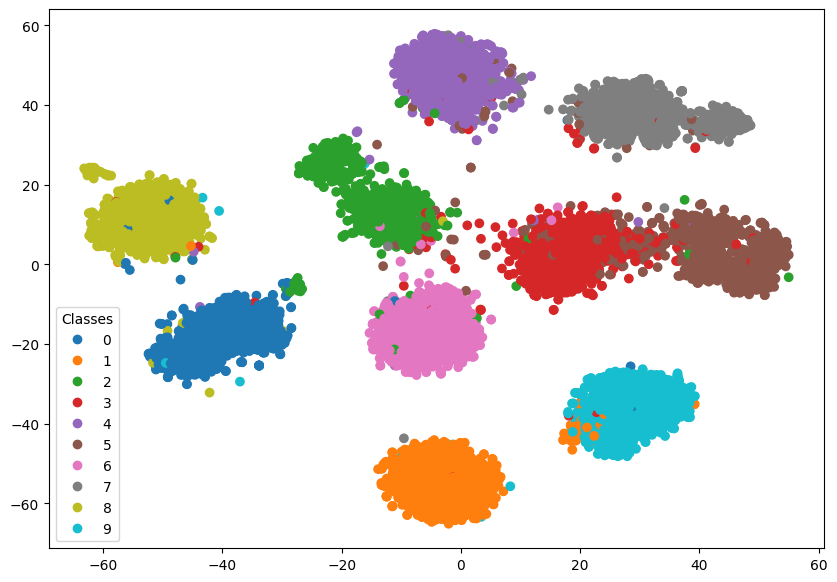

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 减少批量大小
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 从64改为16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # 从64改为16

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

class DS_FusionNet(nn.Module):
    def __init__(self):
        super(DS_FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        # 修改输入通道数为2560（1792 + 768）
        self.deformable_conv = nn.Conv2d(2560, 64, kernel_size=3, padding=1)  # 修正输入通道数
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        eff_out_feat = self.efficientnet.features(x)
        convnext_out_feat = self.convnext.features(x)
        
        # 拼接后的特征通道数为2560
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        fused_feat = self.deformable_conv(fused_feat)  # 输入通道2560，输出64
        fused_feat = self.avgpool(fused_feat)
        fused_feat = fused_feat.view(fused_feat.size(0), -1)
        out = self.fc(fused_feat)
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher) / accumulation_steps
        
        loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_labels

# t-SNE可视化
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# PCA可视化
def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# 混淆矩阵可视化
def plot_confusion_matrix(all_preds, all_labels, title):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# 计算指标
def calculate_metrics(model, teacher_model, device, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return total_loss, accuracy

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DS_FusionNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, 2):
    print(f'Training DS_FusionNet...')
    train(model, teacher_model, device, train_loader, optimizer, epoch)
    print(f'Evaluating DS_FusionNet...')
    all_preds, all_labels = test(model, device, test_loader)

    # Collecting training and testing metrics for learning curves
    train_loss, train_acc = calculate_metrics(model, teacher_model, device, train_loader)
    test_loss, test_acc = calculate_metrics(model, None, device, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

print(f'Visualizing DS_FusionNet...')

# Extract features for visualization
features = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        eff_out_feat = model.efficientnet.features(data)
        convnext_out_feat = model.convnext.features(data)
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        feature_map = fused_feat.mean(dim=(2, 3))
        features.append(feature_map.cpu().numpy())
        labels.extend(target.cpu().numpy())  # 将 target 移动到 CPU

features = np.concatenate(features)
labels = np.array(labels)

visualize_tsne(features, labels, 't-SNE Visualization of DS_FusionNet Features')
visualize_pca(features, labels, 'PCA Visualization of DS_FusionNet Features')
plot_confusion_matrix(all_preds, all_labels, 'Confusion Matrix of DS_FusionNet')

# Plotting Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()





Files already downloaded and verified
Files already downloaded and verified


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You 

Initial Evaluation...

Test set: Average loss: 2.3393, Accuracy: 1018/10000 (10%)

Training DS_FusionNet...


d:\Users\songyanghui\anaconda3\envs\mvpdr\lib\site-packages\torch\nn\functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Evaluating DS_FusionNet...

Test set: Average loss: 0.2414, Accuracy: 9563/10000 (96%)


Initial Training Loss: 2.3382, Initial Training Accuracy: 10.18%
Final Training Loss: 0.1692, Final Training Accuracy: 98.20%
Initial Test Loss: 2.3393, Initial Test Accuracy: 10.18%
Final Test Loss: 0.2414, Final Test Accuracy: 95.63%
Visualizing DS_FusionNet...


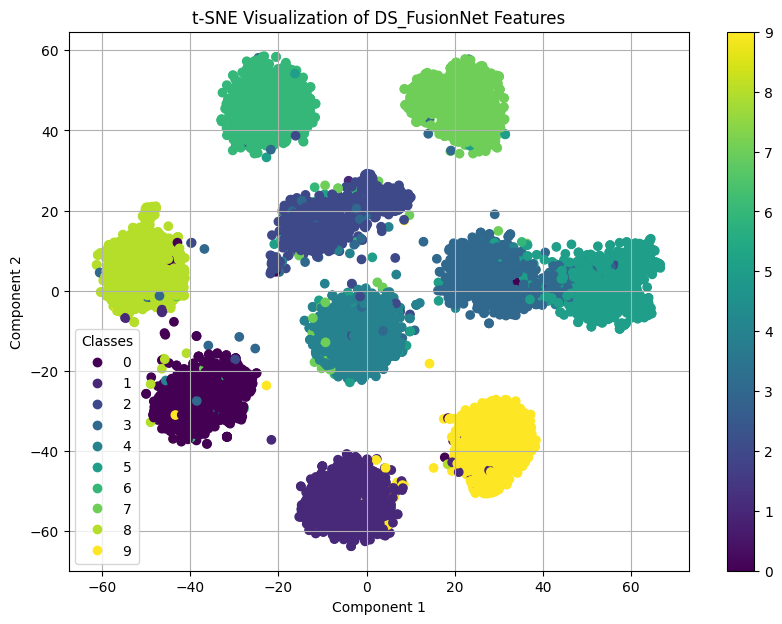

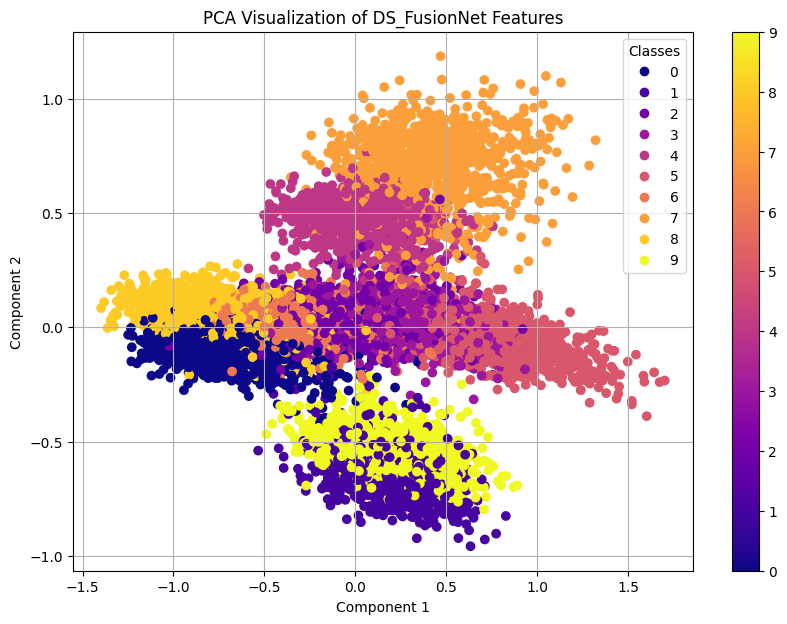

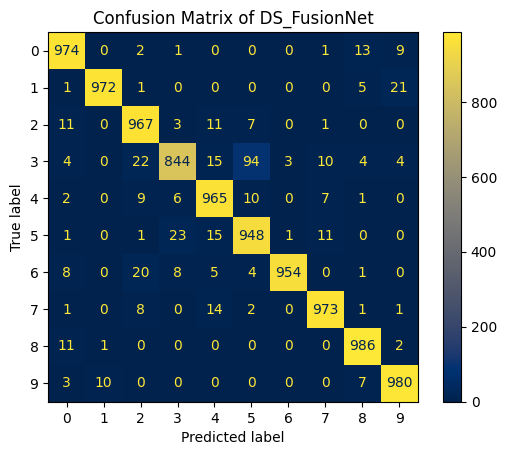

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

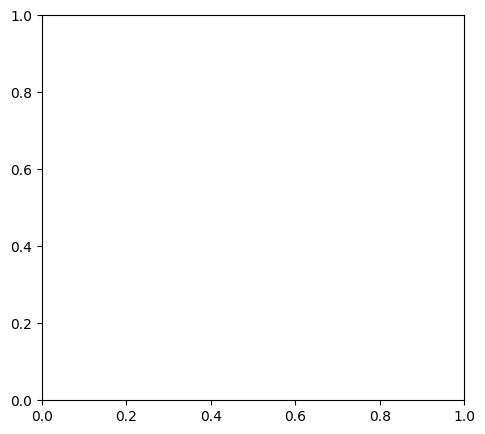

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 减少批量大小
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 从64改为16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # 从64改为16

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

class DS_FusionNet(nn.Module):
    def __init__(self):
        super(DS_FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        # 修改输入通道数为2560（1792 + 768）
        self.deformable_conv = nn.Conv2d(2560, 64, kernel_size=3, padding=1)  # 修正输入通道数
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        eff_out_feat = self.efficientnet.features(x)
        convnext_out_feat = self.convnext.features(x)
        
        # 拼接后的特征通道数为2560
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        fused_feat = self.deformable_conv(fused_feat)  # 输入通道2560，输出64
        fused_feat = self.avgpool(fused_feat)
        fused_feat = fused_feat.view(fused_feat.size(0), -1)
        out = self.fc(fused_feat)
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher) / accumulation_steps
        
        loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_labels

# t-SNE可视化
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis')  # 使用 viridis 配色
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes", loc='best')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter)  # 添加颜色条以显示类别对应的颜色
    plt.grid(True)
    plt.show()

# PCA可视化
def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='plasma')  # 使用 plasma 配色
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes", loc='best')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter)  # 添加颜色条以显示类别对应的颜色
    plt.grid(True)
    plt.show()

# 混淆矩阵可视化
def plot_confusion_matrix(all_preds, all_labels, title):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.cividis)  # 使用 cividis 配色
    plt.title(title)
    plt.show()

# 计算指标
def calculate_metrics(model, teacher_model, device, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return total_loss, accuracy

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DS_FusionNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

# 初始评估
print(f'Initial Evaluation...')
initial_all_preds, initial_all_labels = test(model, device, test_loader)
initial_train_loss, initial_train_acc = calculate_metrics(model, teacher_model, device, train_loader)
initial_test_loss, initial_test_acc = calculate_metrics(model, None, device, test_loader)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, 2):  # 将训练轮数设为1以快速演示
    print(f'Training DS_FusionNet...')
    train(model, teacher_model, device, train_loader, optimizer, epoch)
    print(f'Evaluating DS_FusionNet...')
    all_preds, all_labels = test(model, device, test_loader)

    # Collecting training and testing metrics for learning curves
    train_loss, train_acc = calculate_metrics(model, teacher_model, device, train_loader)
    test_loss, test_acc = calculate_metrics(model, None, device, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

# 最终评估
final_train_loss, final_train_acc = calculate_metrics(model, teacher_model, device, train_loader)
final_test_loss, final_test_acc = calculate_metrics(model, None, device, test_loader)

print(f'\nInitial Training Loss: {initial_train_loss:.4f}, Initial Training Accuracy: {initial_train_acc:.2f}%')
print(f'Final Training Loss: {final_train_loss:.4f}, Final Training Accuracy: {final_train_acc:.2f}%')
print(f'Initial Test Loss: {initial_test_loss:.4f}, Initial Test Accuracy: {initial_test_acc:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.2f}%')

print(f'Visualizing DS_FusionNet...')

# Extract features for visualization
features = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        eff_out_feat = model.efficientnet.features(data)
        convnext_out_feat = model.convnext.features(data)
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        feature_map = fused_feat.mean(dim=(2, 3))
        features.append(feature_map.cpu().numpy())
        labels.extend(target.cpu().numpy())  # 将 target 移动到 CPU

features = np.concatenate(features)
labels = np.array(labels)

visualize_tsne(features, labels, 't-SNE Visualization of DS_FusionNet Features')
visualize_pca(features, labels, 'PCA Visualization of DS_FusionNet Features')
plot_confusion_matrix(all_preds, all_labels, 'Confusion Matrix of DS_FusionNet')

# Plotting Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, 11), test_losses, label='Test Loss', color='orange')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy', color='red')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout() 
plt.show()





Files already downloaded and verified
Files already downloaded and verified
Initial Evaluation...

Test set: Average loss: 2.3224, Accuracy: 1419/10000 (14%)

Training DS_FusionNet Epoch 1/1...
Evaluating DS_FusionNet Epoch 1/1...

Test set: Average loss: 0.1837, Accuracy: 9652/10000 (97%)


Initial Training Loss: 2.3207, Initial Training Accuracy: 14.47%
Final Training Loss: 0.1235, Final Training Accuracy: 98.66%
Initial Test Loss: 2.3224, Initial Test Accuracy: 14.19%
Final Test Loss: 0.1837, Final Test Accuracy: 96.52%
Visualizing DS_FusionNet...


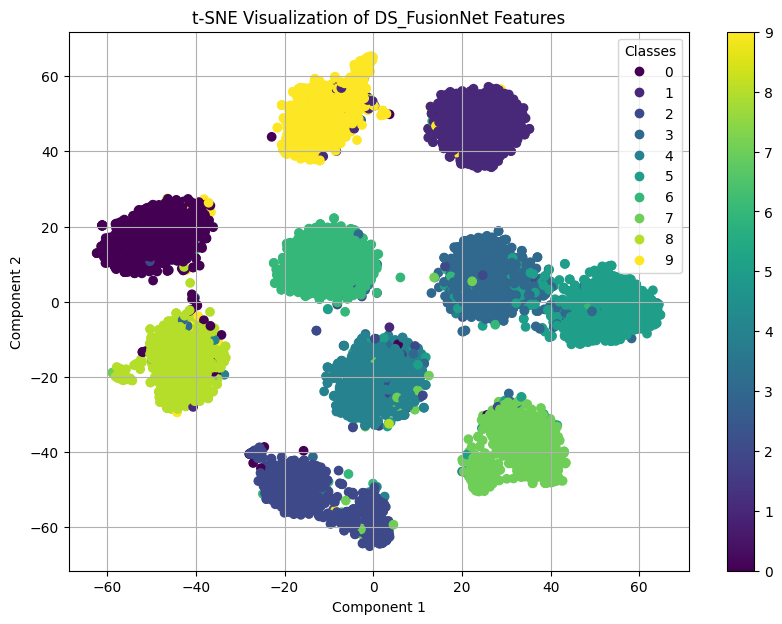

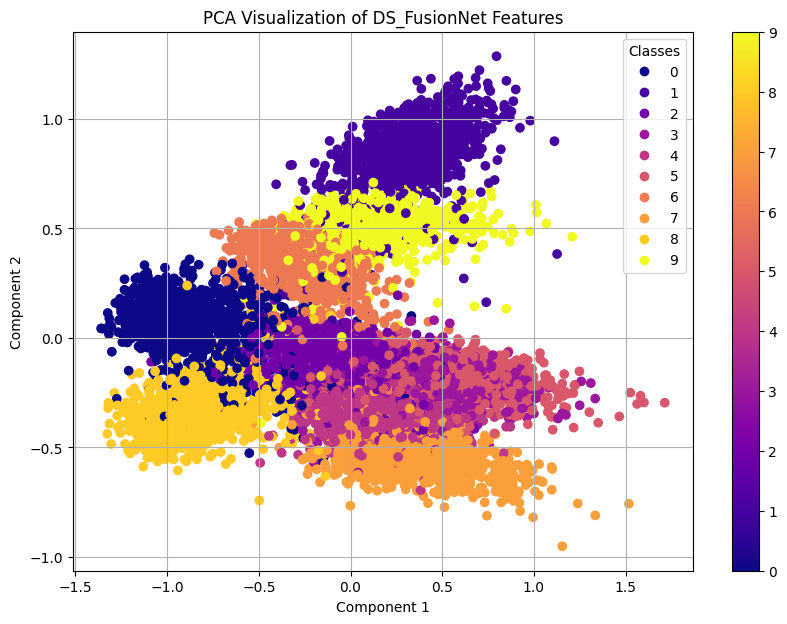

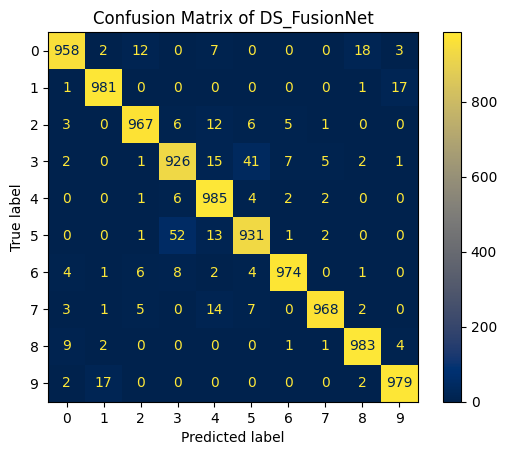

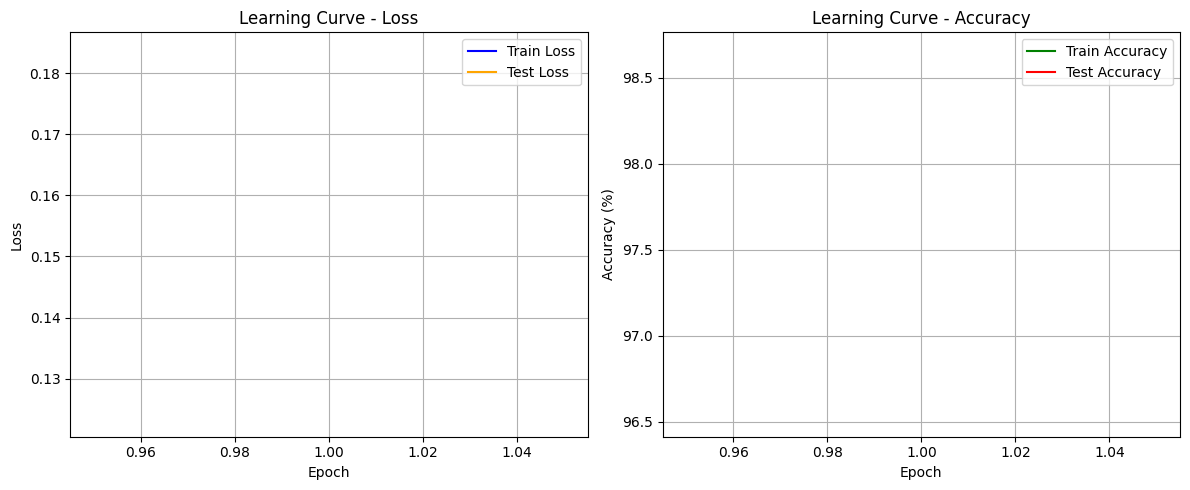

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 减少批量大小
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 从64改为16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # 从64改为16

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

class DS_FusionNet(nn.Module):
    def __init__(self):
        super(DS_FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        # 修改输入通道数为2560（1792 + 768）
        self.deformable_conv = nn.Conv2d(2560, 64, kernel_size=3, padding=1)  # 修正输入通道数
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        eff_out_feat = self.efficientnet.features(x)
        convnext_out_feat = self.convnext.features(x)
        
        # 拼接后的特征通道数为2560
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        fused_feat = self.deformable_conv(fused_feat)  # 输入通道2560，输出64
        fused_feat = self.avgpool(fused_feat)
        fused_feat = fused_feat.view(fused_feat.size(0), -1)
        out = self.fc(fused_feat)
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher) / accumulation_steps
        
        loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_labels

# t-SNE可视化
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis')  # 使用 viridis 配色
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes", loc='best')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter)  # 添加颜色条以显示类别对应的颜色
    plt.grid(True)
    plt.show()

# PCA可视化
def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='plasma')  # 使用 plasma 配色
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes", loc='best')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter)  # 添加颜色条以显示类别对应的颜色
    plt.grid(True)
    plt.show()

# 混淆矩阵可视化
def plot_confusion_matrix(all_preds, all_labels, title):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.cividis)  # 使用 cividis 配色
    plt.title(title)
    plt.show()

# 计算指标
def calculate_metrics(model, teacher_model, device, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return total_loss, accuracy

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DS_FusionNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

# 初始评估
print(f'Initial Evaluation...')
initial_all_preds, initial_all_labels = test(model, device, test_loader)
initial_train_loss, initial_train_acc = calculate_metrics(model, teacher_model, device, train_loader)
initial_test_loss, initial_test_acc = calculate_metrics(model, None, device, test_loader)

num_epochs = 1  # 设置训练轮数为10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):  # 将训练轮数设为10
    print(f'Training DS_FusionNet Epoch {epoch}/{num_epochs}...')
    train(model, teacher_model, device, train_loader, optimizer, epoch)
    print(f'Evaluating DS_FusionNet Epoch {epoch}/{num_epochs}...')
    all_preds, all_labels = test(model, device, test_loader)

    # Collecting training and testing metrics for learning curves
    train_loss, train_acc = calculate_metrics(model, teacher_model, device, train_loader)
    test_loss, test_acc = calculate_metrics(model, None, device, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

# 最终评估
final_train_loss, final_train_acc = calculate_metrics(model, teacher_model, device, train_loader)
final_test_loss, final_test_acc = calculate_metrics(model, None, device, test_loader)

print(f'\nInitial Training Loss: {initial_train_loss:.4f}, Initial Training Accuracy: {initial_train_acc:.2f}%')
print(f'Final Training Loss: {final_train_loss:.4f}, Final Training Accuracy: {final_train_acc:.2f}%')
print(f'Initial Test Loss: {initial_test_loss:.4f}, Initial Test Accuracy: {initial_test_acc:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.2f}%')

print(f'Visualizing DS_FusionNet...')

# Extract features for visualization
features = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        eff_out_feat = model.efficientnet.features(data)
        convnext_out_feat = model.convnext.features(data)
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        feature_map = fused_feat.mean(dim=(2, 3))
        features.append(feature_map.cpu().numpy())
        labels.extend(target.cpu().numpy())  # 将 target 移动到 CPU

features = np.concatenate(features)
labels = np.array(labels)

visualize_tsne(features, labels, 't-SNE Visualization of DS_FusionNet Features')
visualize_pca(features, labels, 'PCA Visualization of DS_FusionNet Features')
plot_confusion_matrix(all_preds, all_labels, 'Confusion Matrix of DS_FusionNet')

# Plotting Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='orange')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='red')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()





In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 减少批量大小
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 从64改为16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # 从64改为16

# 模型定义
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

class FusionNet(nn.Module):
    def __init__(self):
        super(FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        self.fc = nn.Linear(20, 10)  # Corrected input dimension

    def forward(self, x):
        eff_out = self.efficientnet(x)
        convnext_out = self.convnext(x)
        fused_out = torch.cat((eff_out, convnext_out), dim=1)
        out = self.fc(fused_out)
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    teacher_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output_student = model(data)
        with torch.no_grad():
            output_teacher = teacher_model(data)
        loss = distillation_loss(output_student, target, output_teacher) / accumulation_steps
        
        loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_labels

# 特征提取函数
def extract_features(model, dataloader, device, num_samples=1000):
    model.eval()
    features = []
    labels = []

    def hook_fn(module, input, output):
        nonlocal features
        feature_vector = torch.flatten(output, start_dim=1)
        features.append(feature_vector.cpu().numpy())

    # 注册钩子到 EfficientNet 的 classifier 层
    hook = model.efficientnet.classifier.register_forward_hook(hook_fn)

    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            if i * len(data) >= num_samples:
                break
            data, target = data.to(device), target.to(device)
            _ = model(data)
            labels.extend(target.cpu().numpy())

    hook.remove()  # 移除钩子

    features = np.concatenate(features)[:num_samples]
    labels = np.array(labels)[:num_samples]
    return features, labels

# 可视化函数
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.show()

def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.add_artist(legend1)
    plt.title(title)
    plt.show()

def plot_confusion_matrix(all_preds, all_labels, title):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.cividis)  # 使用 cividis 配色
    plt.title(title)
    plt.show()

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
fusion_net = FusionNet().to(device)
teacher_model = load_efficientnet_b4(pretrained=True).to(device)

# 训练参数
optimizer = optim.Adam(fusion_net.parameters(), lr=0.001)

# 训练循环
num_epochs = 10  # 设置训练轮数为10
for epoch in range(1, num_epochs + 1):
    print(f'Starting Epoch {epoch}/{num_epochs}')
    print('Training FusionNet...')
    train(fusion_net, teacher_model, device, train_loader, optimizer, epoch)
    print('Evaluating FusionNet...')
    test_preds, test_labels = test(fusion_net, device, test_loader)
    plot_confusion_matrix(test_preds, test_labels, f'FusionNet Epoch {epoch}')

    # 提取特征并进行可视化
    features, labels = extract_features(fusion_net, test_loader, device)
    visualize_tsne(features, labels, f'FusionNet t-SNE Epoch {epoch}')
    visualize_pca(features, labels, f'FusionNet PCA Epoch {epoch}')

# 最终特征提取和可视化
features, labels = extract_features(fusion_net, test_loader, device)
visualize_tsne(features, labels, 'Final FusionNet t-SNE')
visualize_pca(features, labels, 'Final FusionNet PCA')
plot_confusion_matrix(test_preds, test_labels, 'Final FusionNet Confusion Matrix')





数据集加载和预处理：
使用 torchvision.datasets.CIFAR10 加载 CIFAR-10 数据集。
应用常见的数据增强技术（如随机水平翻转和随机裁剪）以提高模型的泛化能力。
减少训练集大小到 10%，即仅使用 5000 个样本进行训练。
模型定义：
教师模型：使用 EfficientNetB4 和 ConvNeXtTiny 作为教师模型。
学生模型：定义了一个名为 DS_FusionNet 的融合模型，该模型结合了两个教师模型的特征。
双向知识蒸馏损失函数：
结合传统的交叉熵损失和知识蒸馏损失，其中 T 是温度参数，α 是权重参数。
训练和测试函数：
训练函数：支持带教师模型的知识蒸馏训练和不带教师模型的常规训练。
测试函数：计算每个模型在测试集上的准确率，并打印相关信息。
特征提取和可视化：
使用 t-SNE 和 PCA 对模型的特征进行降维和可视化，以便观察不同模型的特征分布差异。
绘制定性结果：
绘制所有模型在多个训练周期中的准确率曲线，以便直观地比较它们的表现。
通过这种方式，你可以在 CIFAR-10 数据集上验证教师-学生网络在小样本条件下的效果，并与常规训练方法进行对比。预期结果是教师-学生网络能够更好地缓解过拟合问题，提升泛化能力和分类性能。

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 定义数据变换
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载 CIFAR-10 数据集
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 减少数据集大小
num_train_samples = int(0.1 * len(train_dataset))  # 使用 10% 的训练样本
indices = list(range(len(train_dataset)))
np.random.seed(42)
np.random.shuffle(indices)
train_sampler = SubsetRandomSampler(indices[:num_train_samples])

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义模型
def load_efficientnet_b4(pretrained=True):
    model = models.efficientnet_b4(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 10)
    return model

def load_convnext_tiny(pretrained=True):
    model = models.convnext_tiny(pretrained=pretrained)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 10)
    return model

class DS_FusionNet(nn.Module):
    def __init__(self):
        super(DS_FusionNet, self).__init__()
        self.efficientnet = load_efficientnet_b4(pretrained=True)
        self.convnext = load_convnext_tiny(pretrained=True)
        self.deformable_conv = nn.Conv2d(2560, 64, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(64 * 7 * 7, 10)  # 10 classes

    def forward(self, x):
        eff_out_feat = self.efficientnet.features(x)
        convnext_out_feat = self.convnext.features(x)
        fused_feat = torch.cat((eff_out_feat, convnext_out_feat), dim=1)
        fused_feat = self.deformable_conv(fused_feat)
        fused_feat = self.avgpool(fused_feat)
        fused_feat = fused_feat.view(fused_feat.size(0), -1)
        out = self.fc(fused_feat)
        return out

# 双向知识蒸馏损失函数
def distillation_loss(y, labels, teacher_scores, T=3, alpha=0.5):
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(y / T, dim=1),
                             nn.functional.softmax(teacher_scores / T, dim=1)) * (alpha * T * T) + \
              nn.CrossEntropyLoss()(y, labels) * (1. - alpha)
    return KD_loss

# 训练函数
def train(model, teacher_model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    if teacher_model is not None:
        teacher_model.eval()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        if teacher_model is not None:
            output_student = model(data)
            with torch.no_grad():
                output_teacher = teacher_model(data)
            loss = distillation_loss(output_student, target, output_teacher) / accumulation_steps
        else:
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target) / accumulation_steps
        
        loss.backward()
        
        if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * accumulation_steps
    
    print(f'Epoch {epoch} Training Loss: {running_loss / len(train_loader):.4f}')

# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return accuracy

# 可视化函数
def visualize_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features)
    plt.figure(figsize=(10, 7))
    plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()

def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)
    plt.figure(figsize=(10, 7))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()

# 特征提取函数
def extract_features(model, dataloader, device, num_samples=1000):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            if i * len(data) >= num_samples:
                break
            data, target = data.to(device), target.to(device)
            
            # 获取中间特征
            if isinstance(model, models.EfficientNet):
                feature_map = model.features(data)
            elif isinstance(model, models.ConvNeXt):
                feature_map = model.features(data)
            elif isinstance(model, DS_FusionNet):
                feature_map = model.forward(data)
            else:
                raise ValueError("Unsupported model type")
                
            # 将特征展平成一维向量
            feature_vector = torch.flatten(feature_map, start_dim=1)
            features.append(feature_vector.cpu().numpy())
            labels.extend(target.cpu().numpy())  # 修正处：添加.cpu()
    
    features = np.concatenate(features)[:num_samples]
    labels = np.array(labels)[:num_samples]
    return features, labels

# 主程序
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
efficientnet = load_efficientnet_b4().to(device)
convnext = load_convnext_tiny().to(device)
fusion_net = DS_FusionNet().to(device)

# 训练参数
optimizer_efficientnet = optim.Adam(efficientnet.parameters(), lr=1e-4)
optimizer_convnext = optim.Adam(convnext.parameters(), lr=1e-4)
optimizer_fusion_net = optim.Adam(fusion_net.parameters(), lr=1e-4)

# 训练循环
num_epochs = 10  # 设置训练轮数为10

print("\nTraining EfficientNet Teacher Model...")
for epoch in range(1, num_epochs + 1):
    print(f'Starting Epoch {epoch}/{num_epochs}')
    train(efficientnet, None, device, train_loader, optimizer_efficientnet, epoch)
    acc_efficientnet = test(efficientnet, device, test_loader)

print("\nTraining ConvNeXt Teacher Model...")
for epoch in range(1, num_epochs + 1):
    print(f'Starting Epoch {epoch}/{num_epochs}')
    train(convnext, None, device, train_loader, optimizer_convnext, epoch)
    acc_convnext = test(convnext, device, test_loader)

print("\nTraining Fusion Net Student Model using EfficientNet and ConvNeXt Teachers...")
accuracies_fusion_net = []
for epoch in range(1, num_epochs + 1):
    print(f'Starting Epoch {epoch}/{num_epochs}')
    train(fusion_net, efficientnet, device, train_loader, optimizer_fusion_net, epoch)
    acc_fusion_net = test(fusion_net, device, test_loader)
    accuracies_fusion_net.append(acc_fusion_net)
    
    # 提取特征并进行可视化
    features, labels = extract_features(fusion_net, test_loader, device)
    visualize_tsne(features, labels, f'Fusion Net t-SNE Epoch {epoch}')
    visualize_pca(features, labels, f'Fusion Net PCA Epoch {epoch}')
    
    # 保存学生模型权重
    student_weights_path = f"FusionNet_student_epoch_{epoch}.pth"
    torch.save(fusion_net.state_dict(), student_weights_path)
    print(f'Saved Fusion Net weights to {student_weights_path}')

# 常规训练部分
regular_models = {
    'EfficientNetB4': load_efficientnet_b4().to(device),
    'ConvNeXtTiny': load_convnext_tiny().to(device),
    'DS_FusionNet': DS_FusionNet().to(device)
}

regular_optimizers = {name: optim.Adam(model.parameters(), lr=1e-4) for name, model in regular_models.items()}

regular_accuracies = {name: [] for name in regular_models.keys()}

print("\nRegular Training for Comparison...")
for name, model in regular_models.items():
    print(f'\nTraining {name}...')
    for epoch in range(1, num_epochs + 1):
        print(f'Starting Epoch {epoch}/{num_epochs}')
        train(model, None, device, train_loader, regular_optimizers[name], epoch)
        acc_regular = test(model, device, test_loader)
        regular_accuracies[name].append(acc_regular)
        
        # 提取特征并进行可视化
        features, labels = extract_features(model, test_loader, device)
        visualize_tsne(features, labels, f'{name} Regular Train t-SNE Epoch {epoch}')
        visualize_pca(features, labels, f'{name} Regular Train PCA Epoch {epoch}')
        
        # 保存模型权重
        model_weights_path = f"{name}_regular_train_epoch_{epoch}.pth"
        torch.save(model.state_dict(), model_weights_path)
        print(f'Saved {name} weights to {model_weights_path}')

# 绘制定性结果
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), accuracies_fusion_net, label='Fusion Net Student', marker='o')
for name, accs in regular_accuracies.items():
    plt.plot(range(1, num_epochs + 1), accs, label=f'{name} Regular Train', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies on Test Set Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



